In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nbimporter
import util

from linear_model import LinearModel
from p01b_logreg import LogisticRegression

In [2]:
ds1_training_set_path = '../data/ds1_train.csv'
ds1_valid_set_path = '../data/ds1_valid.csv'
ds2_training_set_path = '../data/ds2_train.csv'
ds2_valid_set_path = '../data/ds2_valid.csv'

In [3]:
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=False)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=False)

In [4]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        m, n = x.shape
        phi = np.sum(y) / m
        mu_0 = np.dot(x.T, 1 - y) / np.sum(1 - y) # shape (n,)
        mu_1 = np.dot(x.T, y) / np.sum(y) # shape (n,)
        
        # Reshape y as a 2D ndarray for broadcast operations
        y_reshaped = np.reshape(y, (m, -1)) # shape (m, 1)
        
        # Matrix comprises mu_0 and mu_1 based on the value of y. 
        mu_x = y_reshaped * mu_1 + (1 - y_reshaped) * mu_0
        x_centered = x - mu_x
        sigma = 1 / m * np.dot(x_centered.T, x_centered) 
        sigma_inv = np.linalg.inv(sigma)
        
        # Compute theta and theta_0 according to part (c)
        theta = np.dot(sigma_inv, mu_1 - mu_0) # shape (n,)
        theta_0 = 1 / 2 * mu_0 @ sigma_inv @ mu_0 \
                    - 1 / 2 * mu_1 @ sigma_inv @ mu_1 - np.log((1 - phi) / phi)
        
        # Insert theta_0 into the front of the entire theta vector
        self.theta = np.insert(theta, 0, theta_0)
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        # Add x_0 = 1 convention to make predictions using theta^T x >= 0
        return util.add_intercept(x) @ self.theta >= 0
        # *** END CODE HERE

Rewrite the `plot` function in the benchmark to allow for a seond decision boundary:

In [5]:
def plot(x, y, theta_1, legend_1=None, 
               theta_2=None, legend_2=None, title = None, correction=1.0):
    
    # Plot samples with blue and green markings.
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx')
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go')
    
    # Plot decision boundary found with theta_1^T x = 0, 
    #  solving x2 from theta_1[0] + theta_1[1]*x1 + theta_1[2]*x2 = 0
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta_1[0] / theta_1[2] * correction + theta_1[1] / theta_1[2] * x1)
    plt.plot(x1, x2, c='red', label=legend_1)
    
    # Plot decision boundary found by solving for theta_2^T x = 0
    if theta_2 is not None:
        x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
        x2 = -(theta_2[0] / theta_2[2] * correction + theta_2[1] / theta_2[2] * x1)
        plt.plot(x1, x2, c='black', label=legend_2)

    # Add labels, legend and title
    plt.xlabel('x1')
    plt.ylabel('x2')
    if legend_1 is not None or legend_2 is not None:
        plt.legend(loc="upper left")
    if title is not None:
        plt.suptitle(title, fontsize=12)

In [6]:
x_train_intercept, y_train_intercept = util.load_dataset(ds1_training_set_path, add_intercept=True)
x_valid_intercept, y_valid_intercept = util.load_dataset(ds1_valid_set_path, add_intercept=True)

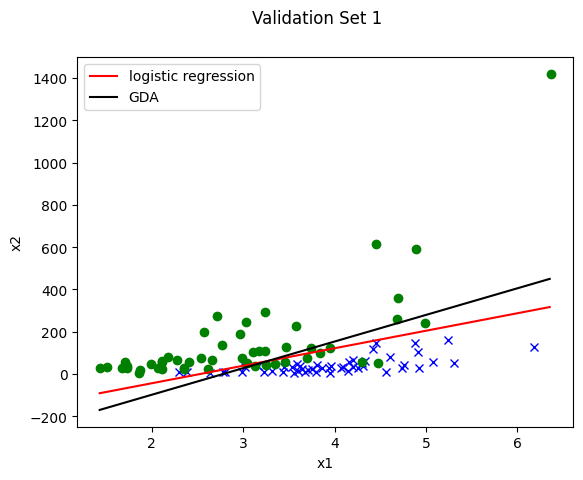

In [7]:
gda = GDA()
gda.fit(x_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(x_train_intercept, y_train_intercept)

plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', 
                       theta_2=gda.theta, legend_2='GDA', title='Validation Set 1')

GDA performs much worse than logistic regression on dataset 1.